In [1]:
%ds_look
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# imports
from __future__ import division
import matplotlib.pyplot as plt, pandas as pd, numpy as np
import datetime
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime
from scipy import linalg
from scipy.stats import norm, zscore
from scipy import interpolate
import ds_api
from ds_api.ds_components import todo_list




from scipy.stats import ks_2samp
from scipy.stats.mstats import ks_twosamp
import time,math
pd.options.display.float_format = '{:,.5f}'.format


import os
import hvac
import psycopg2
import pandas as pd
import requests

requests.packages.urllib3.disable_warnings()

vault = hvac.Client(
  'https://vault-server1.datascience.com:8200', 
  verify='/etc/ssl/certs/vault-ca.cert'
)
vault.auth_github(os.environ['GITHUB_TOKEN'])

vault_resp = vault.read('topix/redshift')
credentials = vault_resp['data']

conn = psycopg2.connect(
    database='stars',
    port=os.environ['REDSHIFT_PORT'],
    password=credentials['password'],
    user=credentials['user'],
    host=credentials['host']
)

@cache()
def results(query):
    return pd.read_sql(query, conn)

In [3]:
palette = ('#6E90A9','#7B74AA','#C86454','#D38252','#DDA051','#E8BE4F','#E24A33')

def leg_clean(ax,loc):
    ax.legend(loc=loc).get_frame().set_color('white')
    
def ax_clean(ax,whitegrid=False,grid='y'):
    ax.set_axis_bgcolor('w')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    if whitegrid:
        ax.grid(color='w', linewidth=0.8, linestyle=':')
        ax.set_axisbelow(False)
    if grid=='x':
        ax.yaxis.grid(b=False)
    if grid=='y':
        ax.xaxis.grid(b=False)
    return ax

def calcbinc(bins):
    binc=[bins[i]+0.5*(bins[1]-bins[0]) for i in range(len(bins)-1)]
    return binc

In [4]:
def scaled_seasonal(hist):
    
    # start of andrea's code for scaled seasonal decomp
    n=4 # period length
    periods=np.floor(len(hist)/n)
    hist_seas=np.asarray(hist[:int(periods*n)]) # chopping off any incomplete cycles on the end

    kernel=np.asarray([.5, 1,1,1, .5])/n # window for averaging
    trend=np.convolve(hist_seas,kernel,mode='same') # find the mean trend
    # fix endpoints, hard coded for n=4 right now
    for j in np.arange(0,2):
        trend[j]=trend[3]
    for j in np.arange(len(hist_seas)-1,len(hist_seas)):
        trend[j]=trend[len(hist_seas)-2]
    hist_seas=hist_seas-trend # subtract out mean

    matform=hist_seas.reshape(int(periods), n) # make into a period=4 matrix
    U, s, Vh = linalg.svd(np.transpose(matform)) # singular value decomposition
    top_sign = np.sum(np.sign(Vh[0,:])) # figure out if most of Vh is pos or neg
    if top_sign>=0:  # in case the SVD did everything with flipped sign
        Vh[np.where(Vh<0)]=0 # remove any flipped weightings of seasonality
    else:
        Vh[np.where(Vh>0)]=0 # remove any flipped weightings of seasonality

    seasonal=np.dot(U[:,0].reshape(n,1),Vh[0,:].reshape(1,periods))*s[0] # constructing the first component
    seasonal=np.transpose(seasonal) # transpose to make the reshaping easier

    clean_dist=hist_seas-seasonal.reshape(1,periods*n)[0]+trend  # remove reshaped seasonality and add back in mean
    clean_dist=np.append(clean_dist,hist[int(periods*n):]) # append back the incomplete data 
    ### end andrea's code  
    
    return clean_dist

def ds_pdf(x,q,B):
    return q**((x-1)**B)-q**(x**B)

def S_func(x,q,B):
    return q**(x**B)

def likelihood(obs,q,B,max_slide,num_recirc):
    res=np.zeros(q.shape)
    for i in np.arange(0,len(obs)):
        res=res+np.log(ds_pdf(obs[i],q,B))
    return num_recirc*np.log(S_func(max_slide,q,B))+res

def weibull_fixcensor(z,N_slides,recirc_samp):

    q_breaks=100
    q_poss = np.linspace(1-(1/10), 1-(1/150), q_breaks)
    B_poss = np.linspace(0.5, 1.2, 50)
    q_pair, B_pair = np.meshgrid(q_poss, B_poss)

    result=likelihood(z,q_pair,B_pair,N_slides,recirc_samp)

    idx=result.argmax()
    row=np.floor(idx/q_breaks)
    col=np.remainder(idx,q_breaks)

    return q_pair[row,col], B_pair[row,col]

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = (2*(s**2)) * ((zp + z)**2) / (d**2)
    print n
    return int(round(n[0]))

def sample_power_difftest(d, s, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) 
    zp = -1 * norm.isf([power])
    n = ((s**2)) * ((zp + z)**2) / (d**2) # fixed this to be a one sample instead of two sample - AT
    return int(round(n[0]))





In [5]:
def p_adjust2(df0_3,df0_2,itemid,printflag):
    dftemp1=df0_3[df0_3.itemid==itemid].reset_index(drop=True)
    dftemp2=df0_2[df0_2.itemid==itemid].reset_index(drop=True)
    #print len(dftemp1),len(dftemp2)
    if len(dftemp1)>0:
        if not pd.isnull(dftemp1.loc[0,'numslides']):
            maxslides=dftemp1.loc[0,'numslides']
            #print maxslides
            z=dftemp2.lastslide
            p=1/np.mean(z)
            #print 'p first=',p
            z_new=dftemp1.lastslide
            origN=len(dftemp2)
            chopN=len(dftemp1)
            missingN=origN-chopN
            #print 'missingN',missingN
            #print chopN
            #print origN
            chop=maxslides-1
            bins=range(1,int(maxslides))  
            binc=calcbinc(bins)
            hist0,bins2=np.histogram(z,10)
            hist_result, bins2 = np.histogram(z_new,bins=bins)
            hist=[i/np.sum(hist0) for i in hist_result]
            
            hist2=scaled_seasonal(hist) # remove seasonality
            hist2=[max(i,0) for i in hist2] # half wave rectify
            hist2=[i/np.sum(hist2) for i in hist2] # re-normalize
            
            # adding in weibull
            
            resamp=np.round(np.asarray(hist2)*chopN*1.0)
            z_new=[] # original subset of the data
            for iter in np.arange(0,len(resamp)):
                if resamp[iter]>0:
                    z_new=np.append(z_new, np.ones(resamp[iter])*(iter+1))
                      
            q_wei, B_wei = weibull_fixcensor(z_new,len(hist2),missingN) # q and B parameters
            weidist=ds_pdf(np.arange(1,(len(hist2)+1)),q_wei,B_wei) # distribution fit for plotting and computing the residual
            x=np.arange(1,1000)
            expwei=np.sum(x*ds_pdf(x,q_wei,B_wei))  # expected value = PVV
            
            # done with weibull, weidist is the new distribution            
            
            resid_temp=[hist2[i]-weidist[i] for i in range(len(hist2))]
            sum_resid=np.sum([resid_temp[ij]**2 for ij in range(1,len(resid_temp))])
            
            if (printflag==1):
                plt.rcParams['figure.figsize'] = (10, 7);
                ax1=plt.axes([0.1, 0.1, .8, .8]);
                #ax1.bar(range(1,len(hist)+1),hist,width=.8,align='center',label='Original Data',alpha=0.3)
                ax1.bar(range(1,len(hist2)+1),hist2,width=.8,align='center',label='Slideshow Data (de-Seasoned)')
                ax1.plot(bins[:-1],weidist,color='g',linewidth=2,label='Adjusted Weibull Distribution')
                ax1.plot([expwei,expwei],[0,.05],'--b',lw=3)
                ax1.text(expwei,.051,'Average last slide = '+str(round(expwei,1)),ha='center')
        
                title=dftemp.loc[0,'title']+'\n'+'Max Slides ='+str(int(maxslides))+'\n'+'Num sessions ='+str(len(dftemp))
                ax1.set_title(title,fontsize=16)
                ax1.set_xlabel('Slide #',fontsize=16)
                ax1.set_ylabel('Probability',fontsize=16)
                ax_clean(ax1)
                leg_clean(ax1,1)
                plt.show()

            snums_temp =bins[:-1]
            idsave3=[]
            for ik in range(len(hist)):
                idsave3.append(id)
           
            return resid_temp,snums_temp,idsave3,expwei, q_wei, B_wei, maxslides
        else:
            return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

In [6]:
def a_b_control_query(date1):
    query = """
        SELECT t1.*
        , CAST(t2.numslides AS INT)
        FROM
            (
            SELECT ssid, itemid, CAST(MAX(slidenum) AS INTEGER) as lastslide
            FROM
                (
            select * from (
                 SELECT ssid
                , itemid, CAST(slidenum AS INTEGER), newsession
                , CONVERT_TIMEZONE ( 'utc','pdt', ts) as ts
                , RANK() OVER (PARTITION BY ssid ORDER BY itemid) AS itemid_rank
                , nth_value(itemid, 1) ignore nulls over(partition by ssid order by ts asc
                        rows between unbounded preceding and unbounded following) as nval
                FROM 
                    (SELECT * FROM pv WHERE DATE(CONVERT_TIMEZONE ( 'utc','pdt', ts))='"""+str(date1)+"""'
                    AND action in ('slideshow','stars/slideshow')
                    AND slidenum NOT LIKE '%-%'
                    AND slidenum != '000'
                    AND left(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
                    AND right(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
                    AND ssid != ''
                    AND layoutname = 'prod-active'
                    AND testname = 'prod-active-test10'
                    AND utm_campaign!=''
                    AND fromrecirc IS NULL
                    AND utm_campaign NOT LIKE '%op%'
                    AND utm_campaign is not null)
                ORDER BY ssid,ts)
                where itemid=nval
                )
            GROUP BY 1,2
            ORDER BY 3 DESC) t1
        JOIN
            (SELECT itemid,max(cast(slidenum as integer)) as numslides
            FROM pv
            WHERE DATE(CONVERT_TIMEZONE ( 'utc','pdt', ts))= '"""+str(date1)+"""'
            AND slidenum NOT LIKE '%-%'
            AND slidenum != '000'
            AND left(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
            AND right(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
            GROUP BY 1) t2
        ON t1.itemid=t2.itemid
                 """
    #print query
    df0 = results(query)
    return df0

In [7]:
def a_b_test_query(date1):
    query = """
        SELECT t1.*
        , CAST(t2.numslides AS INT)
        FROM
            (
            SELECT ssid, itemid, CAST(MAX(slidenum) AS INTEGER) as lastslide
            FROM
                (
            select * from (
                 SELECT ssid
                , itemid, CAST(slidenum AS INTEGER), newsession
                , CONVERT_TIMEZONE ( 'utc','pdt', ts) as ts 
                , RANK() OVER (PARTITION BY ssid ORDER BY itemid) AS itemid_rank
                , nth_value(itemid, 1) ignore nulls over(partition by ssid order by ts asc
                        rows between unbounded preceding and unbounded following) as nval
                FROM 
                    (SELECT * FROM pv WHERE DATE(CONVERT_TIMEZONE ( 'utc','pdt', ts))='"""+str(date1)+"""'
                    AND action in ('slideshow','stars/slideshow')
                    AND slidenum NOT LIKE '%-%'
                    AND slidenum != '000'
                    AND left(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
                    AND right(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
                    AND ssid != ''
                    AND layoutname = 'prod-active'
                    AND testname = 'nav-buttons'
                    AND utm_campaign!=''
                    AND fromrecirc IS NULL
                    AND utm_campaign NOT LIKE '%op%'
                    AND utm_campaign is not null)
                ORDER BY ssid,ts)
                where itemid=nval
                )
            GROUP BY 1,2
            ORDER BY 3 DESC) t1
        JOIN
            (SELECT itemid,max(cast(slidenum as integer)) as numslides
            FROM pv
            WHERE DATE(CONVERT_TIMEZONE ( 'utc','pdt', ts))= '"""+str(date1)+"""'
            AND slidenum NOT LIKE '%-%'
            AND slidenum != '000'
            AND left(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
            AND right(slidenum,1) IN (0,1,2,3,4,5,6,7,8,9)
            GROUP BY 1) t2
        ON t1.itemid=t2.itemid
                 """
    #print query
    df0 = results(query)
    return df0

In [8]:
fname='Data/data_a-b-test_navbuttons.csv'
if not (os.path.isfile(fname)):
    date0=pd.date_range(start='2016-03-14',end='2016-05-01')
    #date0=pd.date_range(start='2016-04-08',end='2016-05-01')
    datestr=date0.map(lambda x: x.strftime('%Y-%m-%d'))
    for i in datestr:
        print 'for test group ...'
        df0=a_b_test_query(i)
        print 'len(df0)',len(df0)
        df0_2=df0.copy()
        df0_2['lastslide']=pd.to_numeric(df0_2.lastslide)
        df0_2['flag'] =df0_2.lastslide!=df0_2.numslides
        df0_3=df0_2[df0_2.flag==True]
        itemids=pd.unique(df0_3.itemid).tolist()

        itemidsave=[]
        expwei_save=[]
        q_wei_save=[]
        B_wei_save=[]
        maxslides_save=[]
        lensave=[]
        for kk,id in enumerate(itemids):
            dftemp1=df0_2[df0_2.itemid==id].reset_index(drop=True)
            dftemp=df0_3[df0_3.itemid==id].reset_index(drop=True)
            maxslides=dftemp.loc[0,'numslides']
            if ((len(dftemp1)>=200)&(maxslides>0)):
                itemidsave.append(id)
                resid_temp,snums_temp,idsave3,expwei, q_wei, B_wei, maxslides=p_adjust2(df0_3,df0_2,id,0)
                expwei_save.append(expwei)
                q_wei_save.append(q_wei)
                B_wei_save.append(B_wei)
                maxslides_save.append(maxslides)
                lensave.append(len(dftemp1))

        frame01=pd.DataFrame({'itemid':itemidsave,'date':i,'lens':lensave,'maxslides':maxslides_save,
                              'expwei':expwei_save,'q_wei':q_wei_save,'B_wei':B_wei_save})
        fname='Data/data_'+str(i)+'_a-b-test_navbuttons2.csv'
        frame01.to_csv(fname, sep=',')    
    
    
fname='Data/data_a-b-control_navbuttons.csv'
if not (os.path.isfile(fname)):  
    date0=pd.date_range(start='2016-03-14',end='2016-05-01')
    #date0=pd.date_range(start='2016-04-08',end='2016-05-01')
    datestr=date0.map(lambda x: x.strftime('%Y-%m-%d'))

    for i in datestr:
        print 'date:',i
        print 'for control group ...'
        df0=a_b_control_query(i)
        print 'len(df0)',len(df0)
        df0_2=df0.copy()
        df0_2['lastslide']=pd.to_numeric(df0_2.lastslide)
        df0_2['flag'] =df0_2.lastslide!=df0_2.numslides
        df0_3=df0_2[df0_2.flag==True]
        itemids=pd.unique(df0_3.itemid).tolist()

        itemidsave=[]
        expwei_save=[]
        q_wei_save=[]
        B_wei_save=[]
        maxslides_save=[]
        lensave=[]
        for kk,id in enumerate(itemids):
            dftemp1=df0_2[df0_2.itemid==id].reset_index(drop=True)
            dftemp=df0_3[df0_3.itemid==id].reset_index(drop=True)
            maxslides=dftemp.loc[0,'numslides']
            if ((len(dftemp1)>=200)&(maxslides>0)):
                itemidsave.append(id)
                resid_temp,snums_temp,idsave3,expwei, q_wei, B_wei, maxslides=p_adjust2(df0_3,df0_2,id,0)
                expwei_save.append(expwei)
                q_wei_save.append(q_wei)
                B_wei_save.append(B_wei)
                maxslides_save.append(maxslides)
                lensave.append(len(dftemp1))

        frame01=pd.DataFrame({'itemid':itemidsave,'date':i,'lens':lensave,'maxslides':maxslides_save,
                              'expwei':expwei_save,'q_wei':q_wei_save,'B_wei':B_wei_save})
        fname='Data/data_'+str(i)+'_a-b-control_navbuttons2.csv'
        frame01.to_csv(fname, sep=',')


In [9]:
fname='Data/data_a-b-test_navbuttons.csv'
if not (os.path.isfile(fname)):
    date0=pd.date_range(start='2016-03-14',end='2016-05-01')
    datestr=date0.map(lambda x: x.strftime('%Y-%m-%d'))
    firstt=1
    for ik,idate in enumerate(datestr):
        fname='Data/data_'+idate+'_a-b-test_navbuttons2.csv'
        if (os.path.isfile(fname)):
            dftemp=pd.read_csv(fname)
            dftemp['date']=pd.to_datetime(idate)
            if (len(dftemp)>0):
                if firstt==1:
                    df3=dftemp.copy()
                    firstt=0
                else:
                    df3=df3.append(dftemp)
    df_test=df3.reset_index(drop=True)
    df_test.to_csv(fname, sep=',')
    print 'len(df_test)=',len(df_test)
else:
    df_test=pd.read_csv(fname)
#    df_test['date']=pd.to_datetime(idate)
    
fname='Data/data_a-b-control_navbuttons.csv'
if not (os.path.isfile(fname)):
    firstc=1
    for ik,idate in enumerate(datestr):
        fname='Data/data_'+idate+'_a-b-control_navbuttons2.csv'
        if (os.path.isfile(fname)):
            dftemp=pd.read_csv(fname)
            dftemp['date']=pd.to_datetime(idate)
            if (len(dftemp)>0):
                if firstc==1:
                    df3=dftemp.copy()
                    firstc=0
                else:
                    df3=df3.append(dftemp)
    df_control=df3.reset_index(drop=True)
    df_control.to_csv(fname, sep=',')
    print 'len(df_control)=',len(df_control)
else:
    df_control=pd.read_csv(fname)
#    df_control['date']=pd.to_datetime(idate)


In [10]:
date0=pd.date_range(start='2016-03-14',end='2016-05-01')
datestr=date0.map(lambda x: x.strftime('%Y-%m-%d'))
common_ids=list(set(df_test.itemid) & set(df_control.itemid)) #these are the common itemids
testval=[]
contval=[]
diffval=[]
for ik,idate in enumerate(datestr):  #for each date compare
    for ij,id in enumerate(common_ids):
        d_test=df_test[(df_test.date==idate)&(df_test.itemid==id)]
        d_control=df_control[(df_control.date==idate)&(df_control.itemid==id)]
        if (len(d_test)>0) & (len(d_control)>0):
            testval.append(d_test.expwei.iloc[0])
            contval.append(d_control.expwei.iloc[0])
            diffval.append(d_test.expwei.iloc[0]-d_control.expwei.iloc[0])
            
        #print idate,id
        #print df_test[(df_test.date==idate)&(df_test.itemid==id)]['expwei']

In [11]:
print len(testval),len(contval),len(diffval)
print np.mean(diffval)
print np.std(diffval)

542 542 542
0.306212864867
10.2380648878


This post reports the results of an A/B test where we compare a test group (nav-buttons) versus a control group to measure if nav-buttons have an effect on model-fit pvv.  


### Key Findings

* Nav-buttons do not appear to have an effect on model fit pvv.
* Nav-buttons showed a tiny positive effect (slideshows with nav-buttons had 0.3 higher page views per visit), but the  result is **not** statistically significant. 

### Limitations of the Analysis

The dates of the analysis span from `3/14/16` to `5/1/16`.  We limited the analysis to individual slideshow-days with at least 200 sessions.  Slideshows had to have data for both the control and test groups to do paired comparisons.

### Results of the A/B test

For each day that the experiment ran, we calculated the model fit pvv difference between the test and control groups for each individual slideshow.  For example, if 20 slideshows had at least 200 sessions in both the control and test groups on a particular day, then we computed 20 differences for that day.

The plot below shows 542 computed differences (for the whole date span) between control and test slideshows.  The difference in model fit pvv is computed as (test - control). Therefore, positive values indicate the test group has improved model-fit pvv, which can be interpreted as an improvement of slideshow quality.  

Analysis of the plot:
  * The mean value of the difference between test and control model-fit pvvs is 0.3.
  * The standard deviation of the data is 10.2
  * The t-test p-value for this data is 0.4869.  This is not significant at the $\alpha=0.05$ level, meaning that there is not an effect.

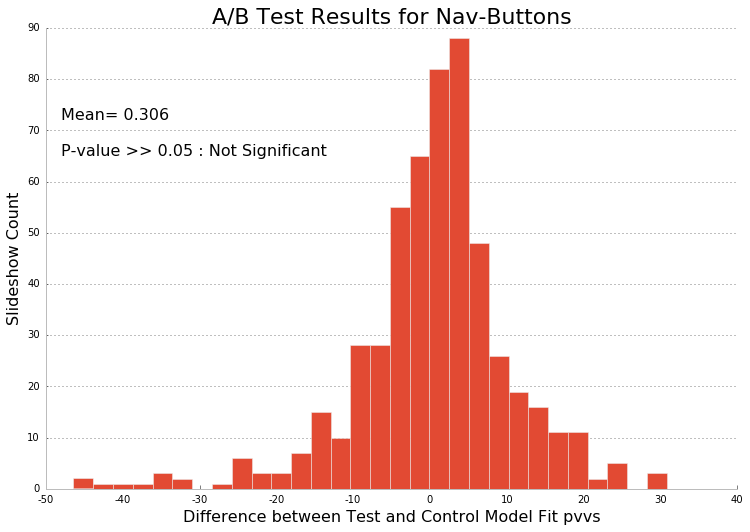

In [49]:
tstat,pvalue = stats.ttest_1samp(diffval,0.0)
plt.rcParams['figure.figsize'] = (12, 8);
ax1=plt.axes([0.1, 0.1, .8, .8]);
ax1.hist(diffval,30,color=palette[6])
#ax1.text(-50,50,str(len(diffval))+' samples',fontsize=16)
#ax1.text(-50,46,'mean of differences = '+str(round(np.mean(diffval),3)),fontsize=16)
ax1.text(-48,72,'Mean= '+str(round(np.mean(diffval),3)),fontsize=16)
#ax1.text(-48,72,'T-stat= '+str(round(tstat,3))+' P-value= '+str(round(pvalue,4)),fontsize=16)
ax1.text(-48,65,'P-value >> 0.05 : Not Significant ',fontsize=16)
#ax1.text(-50,20,'Very large negative outliers may\nbe overly influencing result',fontsize=16)

ax1.set_title('A/B Test Results for Nav-Buttons', fontsize=22)
ax1.set_xlabel('Difference between Test and Control Model Fit pvvs',fontsize=16)
ax1.set_ylabel('Slideshow Count',fontsize=16)
ax1.set_xlim([-50,40])
ax_clean(ax1)
#leg_clean(ax1,1)

plt.show()

### Details of the methodology

In order to control for variable pvvs across different slideshows, we measure pvv differences in individual slideshows as opposed to grouping all slideshows. The figures below illustrate why this is important in A/B testing specifically. 

These figures are examples based on a hypothetical A/B test, for which the pvv differences between the test and control groups is 1 slide. 

The first chart shows test and control pvv distributions for two hypothetical slideshows with different pvvs: slideshow 1 (blue lines, with mean pvv ~50) and slideshow 2 (orange lines, with mean pvv ~80). 

In contrast, the second chart shows test and control pvv distributions when the above slideshows are aggregated. Comparing the two charts, the first method is preferable in preventing information loss because the effect of the A/B test is more readily observed.

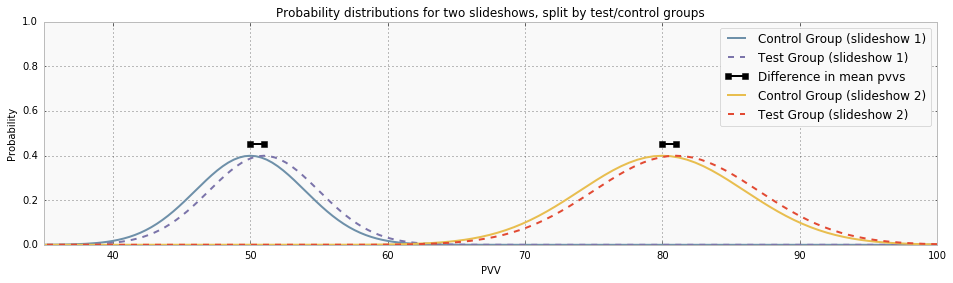

In [27]:
plt.figure(1,figsize=(16,4))
x=np.arange(-50,50,.1)

mean=50
stddev=4
plt.plot(x*stddev+mean,norm.pdf(x),linewidth=2, color='#6E90A9')
plt.plot(x*stddev+(mean+1),norm.pdf(x),'--',linewidth=2, color='#7B74AA')
plt.plot([mean,mean+1],[.45,.45],'k-s',linewidth=2)


mean=80
stddev=6
plt.plot(x*stddev+mean,norm.pdf(x),linewidth=2, color=palette[5])
plt.plot(x*stddev+(mean+1),norm.pdf(x),'--',linewidth=2, color=palette[6])
plt.legend(['Control Group (slideshow 1)','Test Group (slideshow 1)','Difference in mean pvvs',\
            'Control Group (slideshow 2)','Test Group (slideshow 2)'])
plt.plot([mean,mean+1],[.45,.45],'k-s',linewidth=2)

plt.xlim(35,100)
plt.ylim(0,1)
plt.ylabel('Probability')
plt.xlabel('PVV')
plt.title('Probability distributions for two slideshows, split by test/control groups')

#plt.annotate('', xy=(50, 52), xycoords='data',xytext=(50, 52), textcoords='data',
#    arrowprops={'arrowstyle': '|-|'})


#plt.figure(2,figsize=(16,4))
#x=np.arange(-50,50,.1)

plt.show()

For comparison, the plot below shows the pvv distributions for the A and B groups when all slideshows are grouped, such that the variability of mean pvvs across slideshows is not removed. The difference in means relative to the standard deviation is smaller in this case, making the effect of the A/B test more difficult to detect.  Therefore, we propose basing the statistical test on the *difference* in mean pvvs rather than the mean pvvs alone.

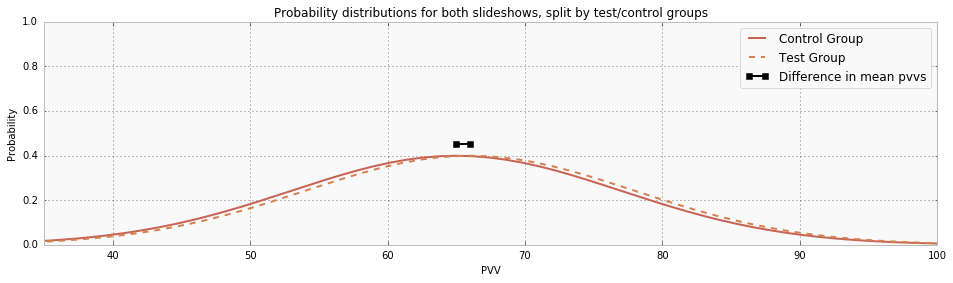

In [30]:

mean=65
stddev=12

plt.figure(1,figsize=(16,4))
x=np.arange(-50,50,.1)
plt.plot(x*stddev+mean,norm.pdf(x),linewidth=2, color=palette[2])
plt.plot(x*stddev+(mean+1),norm.pdf(x),'--',linewidth=2, color=palette[3])
plt.plot([mean,mean+1],[.45,.45],'k-s',linewidth=2)
plt.xlim(35,100)
plt.ylim(0,1)
plt.legend(['Control Group','Test Group', 'Difference in mean pvvs'])
plt.ylabel('Probability')
plt.xlabel('PVV')
plt.title('Probability distributions for both slideshows, split by test/control groups')

#mean=0
#stddev=8.7
#plt.plot(x*stddev+mean,norm.pdf(x),linewidth=2, color='#6E90A9')
#plt.plot(x*stddev+(mean+1.2),norm.pdf(x),'--',linewidth=2, color='#6E90A9')
#plt.legend(['A Group','B Group'])
#plt.xlim(-30,35) #65
#plt.ylim(0,1)
#plt.ylabel('Probability')
#plt.xlabel('PVV')
#plt.title('Probability distributions for two slideshows, split by A/B test groups')


plt.show()

### Statistical Power Analysis 

The statistical power is the probability that the test correctly rejects the null hypothesis ($H_0$) when the alternative hypothesis ($H_1$) is true. Or, more simply, the probability that the test will detect a true difference.  The power of a test is dependent on the number of samples, the size of the effect, standard deviation, test type, among other factors.  The plot below shows how the power is affected by sample size.

For this A/B test the power as a function of sample size is plotted as a blue line (effect size=0.3, $\sigma=10.2$).  This test has a total sample size of 542, the statistical power is 0.10 (see blue square and dashed lines).  Thus, we are very under-powered - 0.80 is the typically accepted value.  In order to detect an effect of 0.3 slides, we should collect around 8700 samples.  If the effect size were a value of 1.23, then our sample size of 542 would be enought to reach the 0.8 threshold (green square and dashed lines).

The other lines on the chart show how fewer samples are needed for A/B tests with equivalent $\sigma$ but larger effect sizes.

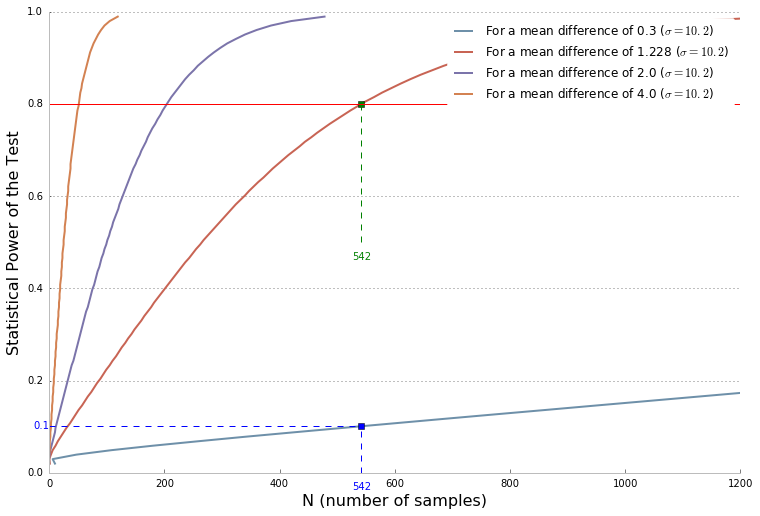

In [15]:
nsave=[]
nsave01=[]
nsave02=[]
nsave03=[]
nsave04=[]

nsave05=[]
nsave10=[]
powsave=np.linspace(0.02,0.99,101)
for ipow in powsave:
    nsave.append(sample_power_difftest(0.3, 10.2, power=ipow, sig=0.05))
    nsave01.append(sample_power_difftest(1.228, 10.2, power=ipow, sig=0.05))
    nsave02.append(sample_power_difftest(2.0, 10.2, power=ipow, sig=0.05))
    nsave04.append(sample_power_difftest(4.0, 10.2, power=ipow, sig=0.05))

x = nsave
y = powsave
f = interpolate.interp1d(x, y)

xnew = 542
ynew = f(xnew)   # use interpolation function returned by `interp1d`


plt.rcParams['figure.figsize'] = (12, 8);
ax1=plt.axes([0.1, 0.1, .8, .8]);
ax1.plot(nsave,powsave,lw=2,color=palette[0],label='For a mean difference of 0.3 ($\sigma=10.2$)')
ax1.plot(nsave01,powsave,lw=2,color=palette[2],label='For a mean difference of 1.228 ($\sigma=10.2$)')
ax1.plot(nsave02,powsave,lw=2,color=palette[1],label='For a mean difference of 2.0 ($\sigma=10.2$)')
ax1.plot(nsave04,powsave,lw=2,color=palette[3],label='For a mean difference of 4.0 ($\sigma=10.2$)')

ax1.plot(xnew,ynew,'sb')
ax1.plot([0,xnew],[ynew,ynew],'--b')
ax1.plot([xnew,xnew],[0,ynew],'--b')
ax1.text(xnew,-.02,xnew,color='b',va='top',ha='center')
ax1.text(-.02,ynew,round(ynew,2),color='b',va='center',ha='right')   
    
nsave1=sample_power_difftest(1.2280, 10.2, power=0.8, sig=0.05)

x = nsave1
y = 0.8

ax1.plot(x,y,'sg')
ax1.plot([x,x],[.5,y],'--g')
ax1.text(x,.48,nsave1,color='g',va='top',ha='center')

ax1.plot([0,1500],[.8,.8],'-r')
ax1.set_xlabel('N (number of samples)',fontsize=16)
ax1.set_ylabel('Statistical Power of the Test',fontsize=16)
ax_clean(ax1)
leg_clean(ax1,1)
ax1.set_xlim([0,1200])

plt.show()

In [16]:

for i in np.asarray([0.3,1,2,3,4,5,10]):
    print sample_power_difftest(i, 5, power=0.8, sig=0.05)
    
for i in np.asarray([0.3,1,2,3,4,5,10]):
    print sample_power_difftest(i, 10, power=0.8, sig=0.05)    

2180
196
49
22
12
8
2
8721
785
196
87
49
31
8


The reference table below lists the necessary sample size to acheive a power of at least 0.8 for different A/B test outcomes.  This is the volume of slideshow-day data points that are needed before conducting a statistical analysis of the A/B test outcome.

|Mean Slide Difference|Std Dev of A/B effect| Minimum sample size|
|-----|-----|-----|
|1 |5| 196|
|2 |5| 49|
|3 |5| 22|
|4 |5| 12|
|5 |5| 8|
|-----|-----|-----|
|0.3|10|8721|
|1 |10| 785|
|2 |10| 196|
|3 |10| 87|
|4 |10| 49|
|5 |10| 31|




### Impact and Further Opportunities

This analysis showed that the effect of nav-buttons on slideshow quality is insignificant. Furthermore, we have unpacked the A/B testing methodology used to measure this test. We can build upon this methodology in analyses of other A/B tests. 

This test will be posed in formal statistics notation.
 > **Null Hypothesis ($H_0$)**:  The change in the slideshow has no effect on model fit pvv.

 > **Alternative Hypothesis ($H_1$)**: The change in the slideshow does have an effect on model fit pvv.
 
 

* Due to the current sample size and the small effect the study is highly under-powered; only 10% of tests would detect the result, less than the commonly accepted 80% threshold.

In practice, one would want to focus on large positive effect sizes and avoid any negative effects.  To do this, we recommend that each A/B test start with a small pilot experiment, after which the effect size and necessary sample size are estimated, and then continue if a sufficiently large positive effect size is expected or halt if a negative effect might occur.  
